In [13]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

In [14]:
# Reading the processed file
df = pd.read_pickle('../output/06062022_clean_data.pkl')

In [15]:
def count_words(df, column='lemmas', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)


def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400,
                   background_color="black", colormap="Paired",
                   max_font_size=150, max_words=max_words)
    # convert DataFrame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


# Frequency Word Clouds

Word Cloud: 2010
Word Cloud: 2011
Word Cloud: 2012


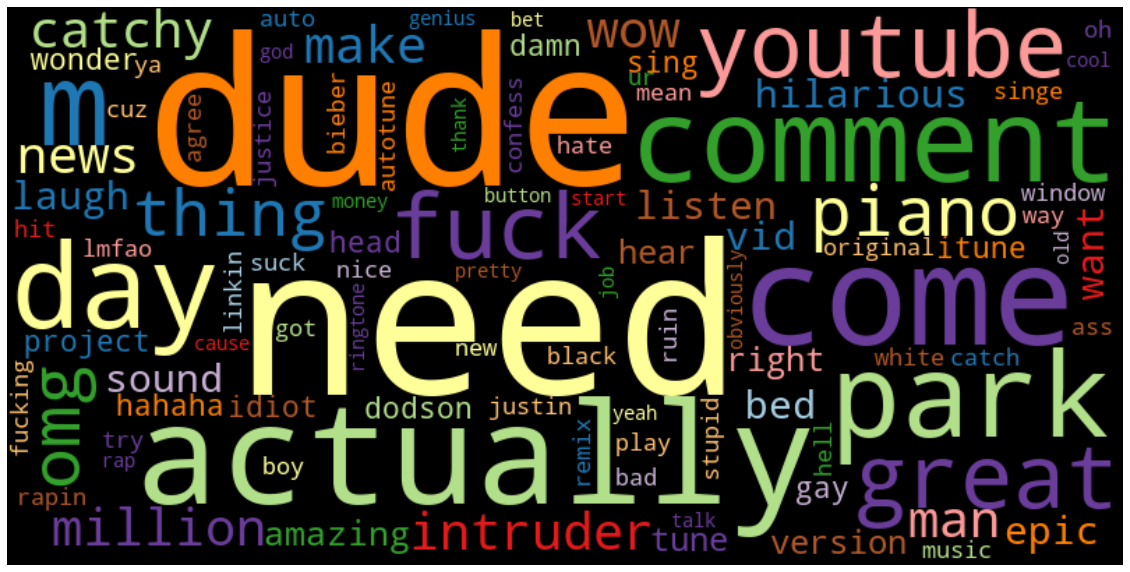

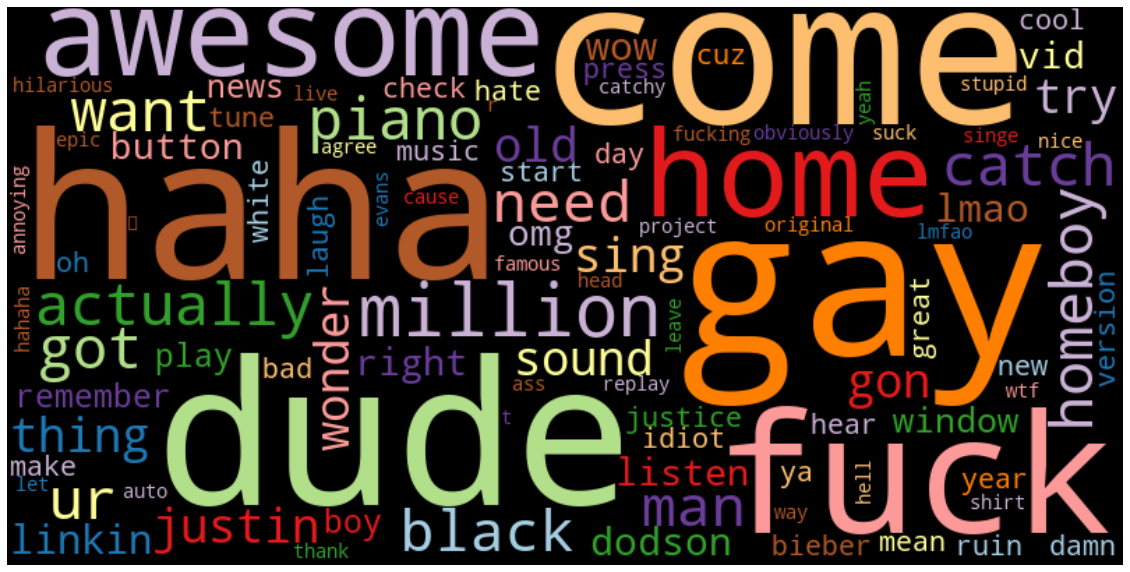

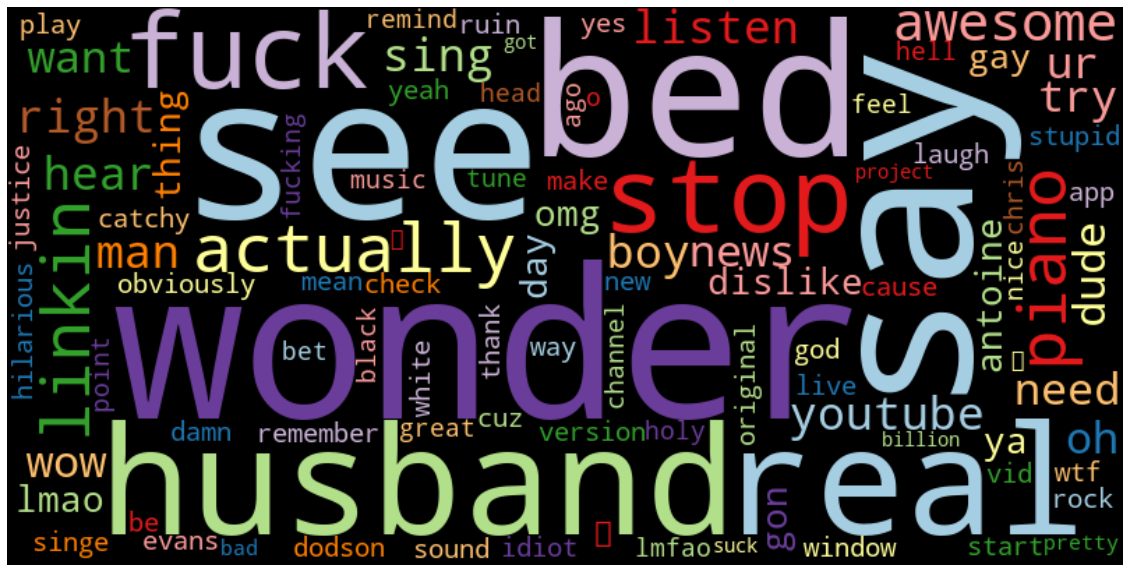

In [16]:
years = ['2010', '2011', '2012']
for year in years:
    df_year = df[df['year'] == year]
    freq_df = count_words(df_year)

    plt.figure(figsize=(20, 20))
    print(f'Word Cloud: {year}')
    #wordcloud(freq_df['freq'], max_words=100)
    wordcloud(freq_df['freq'], max_words=100, stopwords=freq_df.head(50).index)


# IDF Based WordClouds

/var/folders/8r/h6d_m6c551n1g87q75lclwz40000gn/T/ipykernel_13906/187360668.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df) / idf_df['df']) + 0.1


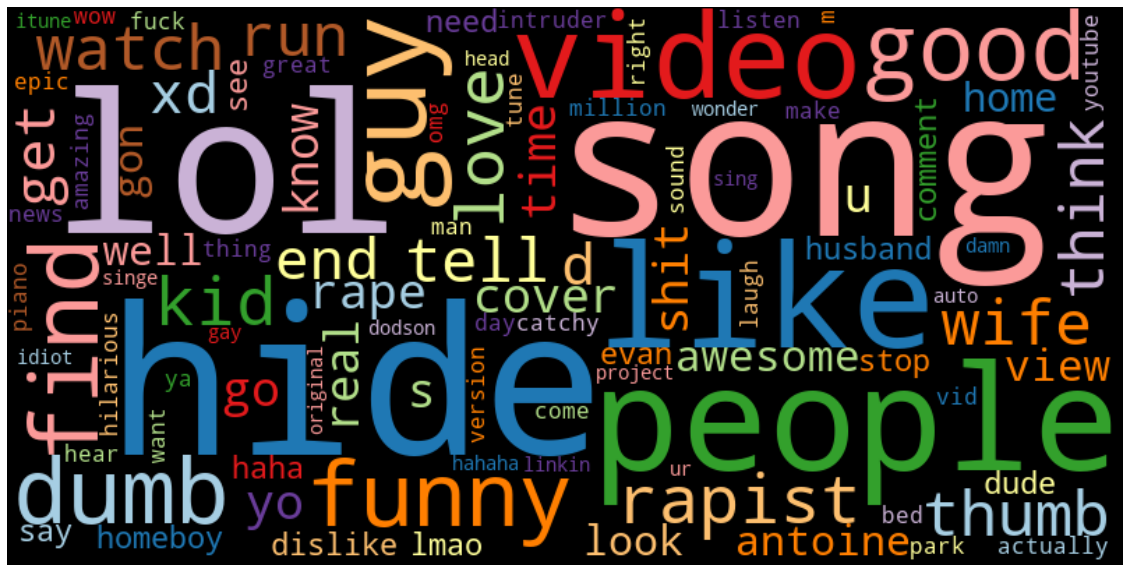

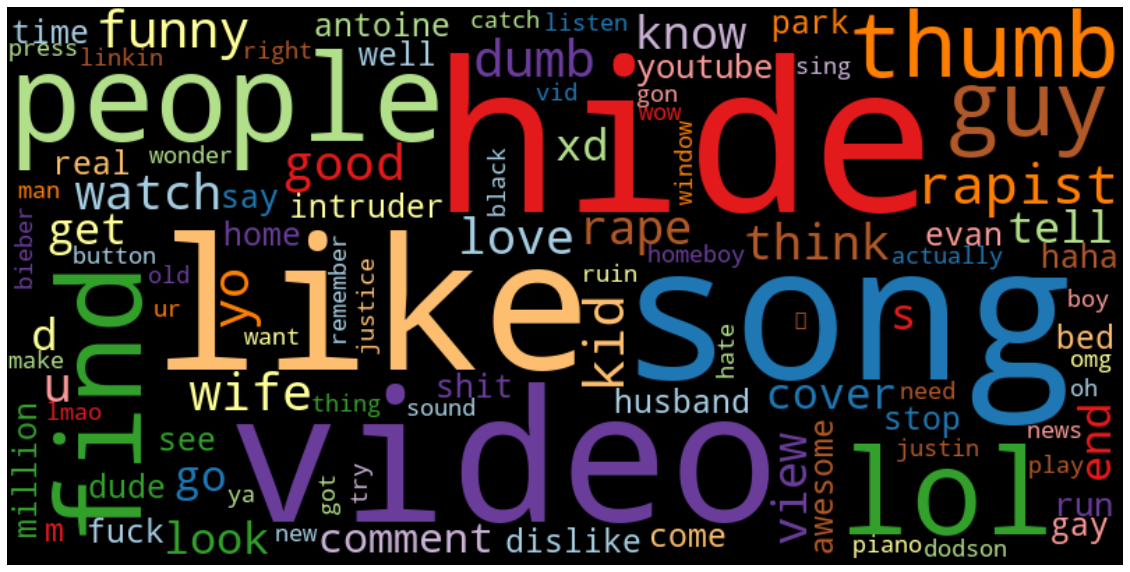

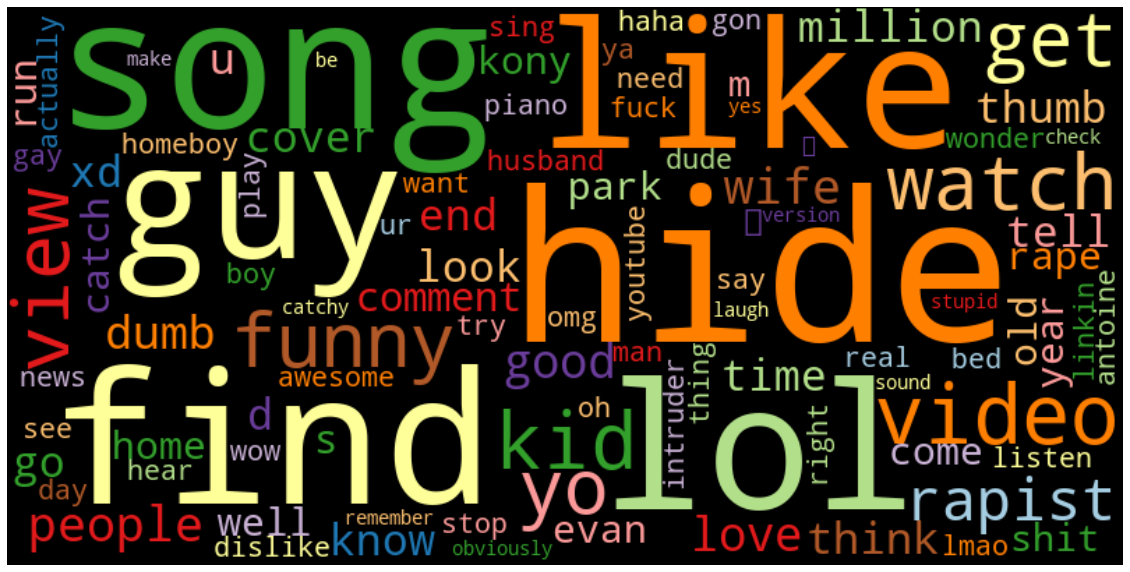

In [17]:
def compute_idf(df, column='lemmas', preprocess=None, min_df=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].map(update)
    # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df) / idf_df['df']) + 0.1
    idf_df.index.name = 'token'
    return idf_df


years = ['2010', '2011', '2012']
for year in years:
    df_year = df[df['year'] == year]
    freq_df = count_words(df_year)
    tfidf_df = compute_idf(df_year)
    freq_df['tfidf'] = freq_df['freq'] * tfidf_df['idf']
    plt.figure(figsize=(20, 20))
    wordcloud(freq_df['tfidf'], max_words=100)
    #wordcloud(freq_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

# Keyword Counts

<AxesSubplot:xlabel='year'>

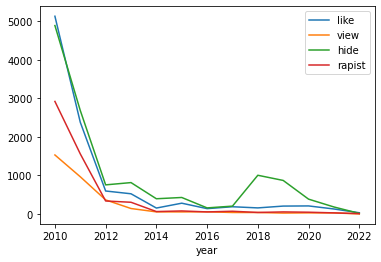

In [18]:
keywords = ['like', 'view', 'hide', 'rapist']
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]


def count_keywords_by(df, by, keywords, column='lemmas'):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]  # copy the grouping column(s)
    return freq_df.groupby(by=by).sum().sort_values(by)


freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df.plot(kind='line')